In [1]:
! pwd

/home/guillermo.carrilho/PhysicsSimulationDeepLearning


In [1]:
import os
import sys


ROOT="/home/guillermo.carrilho/PhysicsSimulationDeepLearning"

sys.path.append(os.path.join(ROOT,"Physical_models"))

# stable difusion approach

In [38]:
from Differentiable_simulation import dK_w,K_w,K_o,grad_phi_dK
from phi.torch.flow import *


geo=UniformGrid(x=500, y=500,bounds=Box(x=5e3, y=5e3))
phi_w=Field( geo,values=tensor(0.0),
      boundary= {
          'x-':4e3,
          'x+': 4e3,
          'y-': ZERO_GRADIENT,
          'y+': ZERO_GRADIENT
 })

dtphi_w_1=Field( geo,values=tensor(0.0),
      boundary= {
          'x-': ZERO_GRADIENT,
          'x+': ZERO_GRADIENT,
          'y-': ZERO_GRADIENT,
          'y+': ZERO_GRADIENT
 })

phi_o=Field( geo,values=tensor(1142.0),
      boundary= {
          'x-': 2e3,
          'x+': ZERO_GRADIENT,
          'y-': ZERO_GRADIENT,
         'y+': ZERO_GRADIENT
 })#
dtphi_o_1=Field( geo,values=tensor(0.0),
      boundary= {
          'x-': ZERO_GRADIENT,
          'x+': ZERO_GRADIENT,
          'y-': ZERO_GRADIENT,
          'y+': ZERO_GRADIENT
 })

phy=two_phase_flow(
   phi_w,
    phi_o,
    dtphi_w_1,
    dtphi_o_1,
    dt=0.01,
    #w_advection_solver=lambda v: Solve('CG',1e-4,1e-4,x0=v),
    w_advection_solver=lambda v: Solve('CG-adaptive',1e-4,1e-4,x0=v),
    #o_advection_solver=lambda v: Solve('CG',1e-4,1e-4,x0=v)
    o_advection_solver=lambda v: Solve('CG-adaptive',1e-4,1e-4,x0=v)
)

from Differentiable_simulation import K_o_f_t,K_w_f_t,S_w,dK_o,dK_w,dK_o,dsdpc
#from Differentiable_simulation import *
#dsdpc=(lambda p_c:math.clip((-1*LAMBDA)*((S_w(p_c)-SWR)/PD),lower_limit=1e-6))
import anisotropic_diffusion
print(phy.compute_p_c(phi_w,phi_o))
print(S_w(phy.compute_p_c(phi_w,phi_o)))
print(K_w_f_t(S_w(phy.compute_p_c(phi_w,phi_o))))
print(dsdpc(phy.compute_p_c(phi_w,phi_o)))

print(dK_w(phy.compute_p_c(phi_w,phi_o)))
print(K_w(phy.compute_p_c(phi_w,phi_o)))
print(phy.compute_convective_velocity(phi_o,phi_w,dK_w,dK_o).sample(phi_w.geometry))
print(K_o(phy.compute_p_c(phi_w,phi_o)))
print(dK_o(phy.compute_p_c(phi_w,phi_o)))
#print(phy.compute_convective_velocity(phi_w,phi_o,dK_w,dK_o).sample(phi_o.geometry))
print(phy.phi_w_momentum_eq(phi_w,phi_o, 1e-4).sample(phi_o.geometry))

PD=2e3
SWR=0.3
SOR=0.1
print((lambda s_w:PD*((s_w-SWR)/(1-SWR)))(0.3))
print((lambda s_w:PD*((s_w-SWR)/(1-SWR)))(0.7))

(xˢ=500, yˢ=500) const 1142.0
(xˢ=500, yˢ=500) const 0.8999999761581421
(xˢ=500, yˢ=500) const 0.049999989569187164
(xˢ=500, yˢ=500) const 9.999999974752427e-07
(dKKᵇ=2, dkᵇ=2, xˢ=500, yˢ=500) 0.083 ± 0.083 (0e+00...2e-01)
(KKᵇ=2, kᵇ=2, xˢ=500, yˢ=500) 2.50e+04 ± 2.5e+04 (0e+00...5e+04)
(xˢ=500, yˢ=500, vectorᶜ=x,y) -0.007 ± 0.226 (-7e+00...0e+00)
(KKᵇ=2, kᵇ=2, xˢ=500, yˢ=500) 3.49e-21 ± 3.5e-21 (0e+00...7e-21)
(dKKᵇ=2, dkᵇ=2, xˢ=500, yˢ=500) 5.47e-19 ± 5.5e-19 (0e+00...1e-18)


Diverged: Solve diverged within 891 iterations using Φ-ML CG (PyTorch*)

In [ ]:
import matplotlib.pyplot as plt

class two_phase_flow(object):
  def __init__(self,phi_w,phi_o,dtphi_w_1,dtphi_o_1,dt,w_advection_solver,o_advection_solver):
    #self.v0=v0
    self.phi_w=phi_w
    self.phi_o=phi_o
    self.dtphi_o_1=dtphi_o_1
    self.dtphi_w_1=dtphi_w_1
    self.dt=dt
    self.p=None
    self.w_advection_solver=w_advection_solver
    self.o_advection_solver=o_advection_solver


  def compute_p_c(self,phi_w,phi_o):
    p_c=phi_o.sample(phi_o.geometry) -\
    phi_w.sample(phi_w.geometry)
    return p_c

  def compute_convective_velocity(self,phi_a,phi_b,dK_a,dK_b):
    p_c=self.compute_p_c(self.phi_w,self.phi_o)
    convective_velocity = grad_phi_dK(phi_a,dK_a(p_c))\
                         - grad_phi_dK(phi_b,dK_b(p_c))

    V=unstack(convective_velocity,"dk")
    convective_velocity=Field(self.phi_o.geometry,values=vec(x=V[0],y=V[1]))
    return convective_velocity

  #def compute_anisotropic_viscosity_effect(self):
    # reformulate differential solver
    
  def phi_w_momentum_eq(self,phi_w,phi_o, dt):
    #grad_phi_w=field.spatial_gradient(self.phi_w,self.phi_w.boundary)
    p_c=self.compute_p_c(phi_w,phi_o)
    w_advection_term = dt * advect.semi_lagrangian((phi_w),
                                                    self.compute_convective_velocity(phi_w,phi_o,dK_w,dK_o),
                                                    dt).sample(phi_w.geometry)

    w_diffusion_term = dt * anisotropic_diffusion.implicit(phi_w,-1*K_w(p_c), dt=dt,correct_skew=False).sample(phi_w.geometry)
    #o_diffusion_term = dt * anisotropic_diffusion.implicit(phi_o,K_o(p_c), dt=dt,correct_skew=False).sample(phi_w.geometry)

    pressure_chage_term = dt * (self.dtphi_o_1)

    return phi_w + phi_w.with_values(pressure_chage_term) + phi_w.with_values(w_advection_term) + phi_w.with_values(w_diffusion_term)
    #return phi_w + phi_w.with_values(pressure_chage_term) + phi_w.with_values(w_diffusion_term)
    #return phi_w + phi_w.with_values(w_diffusion_term)
  
  def phi_o_momentum_eq(self,phi_o,phi_w, dt):
    #grad_phi_w=field.spatial_gradient(phi_w,phi_w.boundary)
    p_c=self.compute_p_c(phi_w,phi_o)

    o_advection_term = dt * advect.semi_lagrangian((phi_o),
                                                    self.compute_convective_velocity(phi_w,phi_o,dK_w,dK_o),
                                                    dt).sample(phi_o.geometry)

    o_diffusion_term = dt * anisotropic_diffusion.implicit(phi_o,-1*K_o(p_c), dt=dt,correct_skew=False).sample(phi_o.geometry)

    pressure_chage_term = dt * (self.dtphi_w_1)

    return phi_o + phi_o.with_values(pressure_chage_term) + phi_o.with_values(o_advection_term) + phi_o.with_values(o_diffusion_term)
    #return phi_o + phi_o.with_values(pressure_chage_term) + phi_o.with_values(o_diffusion_term)
    #return phi_o + phi_o.with_values(o_diffusion_term)
  
  def compute_phi_k(self,phi_w,phi_o,phi_w_1,phi_o_1,dt):
    print(((phi_o-phi_o_1)/dt).sample(geo))
    return (phi_w-phi_w_1)/dt,(phi_o-phi_o_1)/dt


  def implicit_time_step(self, phi_w,phi_o, dt):
    new_phi_w = math.solve_linear(self.phi_w_momentum_eq, phi_w, self.w_advection_solver(phi_w),phi_o, dt=-dt)
    print("w phse solved")
    new_phi_o = math.solve_linear(self.phi_o_momentum_eq, phi_o, self.o_advection_solver(phi_o),phi_w, dt=-dt)
    print("o phse solved")
    print(phi_o.sample(geo))
    print(new_phi_o.sample(geo))
    self.dtphi_w_1,self.dtphi_o_1=self.compute_phi_k(new_phi_w,new_phi_o,phi_w,phi_o, dt)
    return new_phi_w,new_phi_o

In [ ]:
phi=(phi_w,phi_o)

In [ ]:
print(phy.dtphi_o_1.sample(geo))
print(phy.dtphi_w_1.sample(geo))
print(dsdpc(phy.compute_p_c(*phi)))
print(phy.dtphi_o_1.sample(geo)/(dsdpc(phy.compute_p_c(*phi))))
print(phy.dtphi_w_1.sample(geo)/(dsdpc(phy.compute_p_c(*phi))))

(xˢ=500, yˢ=500) const 0.0
(xˢ=500, yˢ=500) const 0.0
(xˢ=500, yˢ=500) const 9.999999974752427e-07
(xˢ=500, yˢ=500) const 0.0
(xˢ=500, yˢ=500) const 0.0


In [ ]:
phi=(phi_w,phi_o)
for i in range(1):
    phi=phy.implicit_time_step(*phi,1e-4)

Diverged: Solve diverged within 891 iterations using Φ-ML CG (PyTorch*)

(xˢ=500, yˢ=500) -5.24e+01 ± 3.3e+05 (-5e+06...5e+06)
(xˢ=500, yˢ=500) const 0.0
(xˢ=500, yˢ=500) const 1142.0


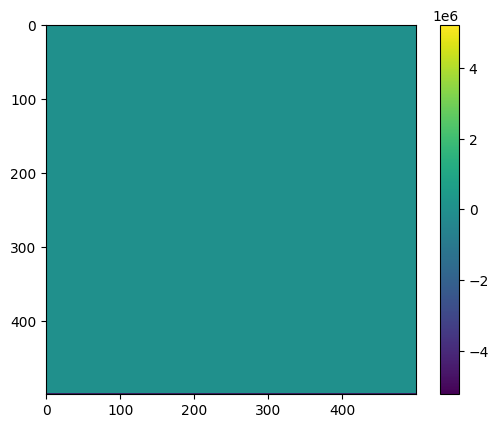

In [ ]:
#plt.imshow(phy.dtphi_o_1.sample(geo))
plt.imshow(phy.dtphi_w_1.sample(geo))
plt.colorbar()
print(phy.dtphi_w_1.sample(geo))
print(phy.dtphi_o_1.sample(geo))
print(phy.phi_o.sample(geo))

(xˢ=500, yˢ=500) -5.24e-05 ± 3.3e-01 (-5e+00...5e+00)


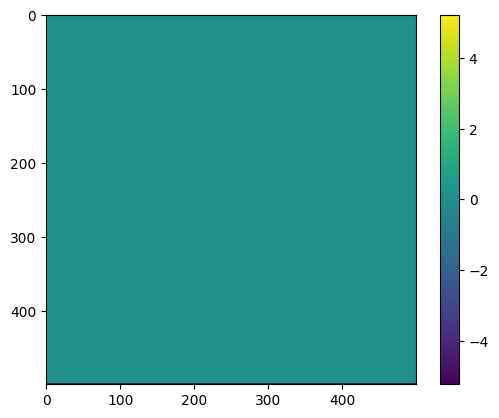

(xˢ=500, yˢ=500) const 1142.0


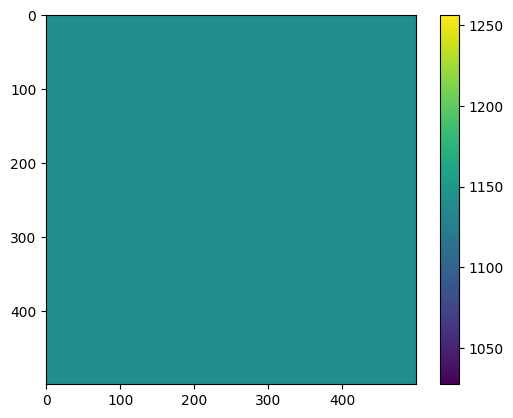

(xˢ=500, yˢ=500) const 0.8999995589256287


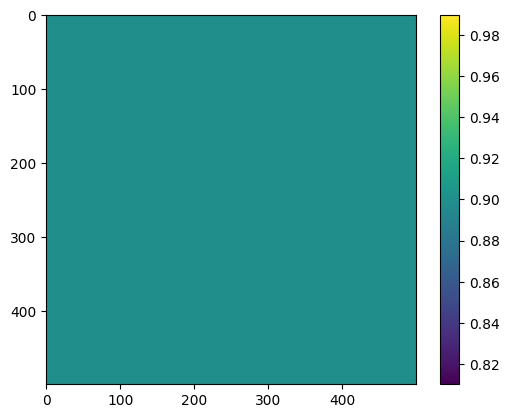

(xˢ=500, yˢ=500) 1.14e+03 ± 3.3e-01 (1e+03...1e+03)


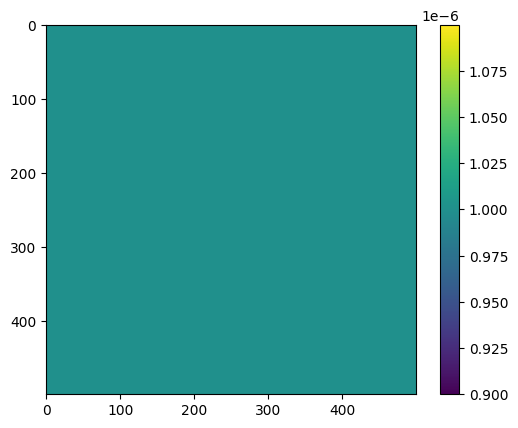

(xˢ=500, yˢ=500) const 1.0000001111620804e-06


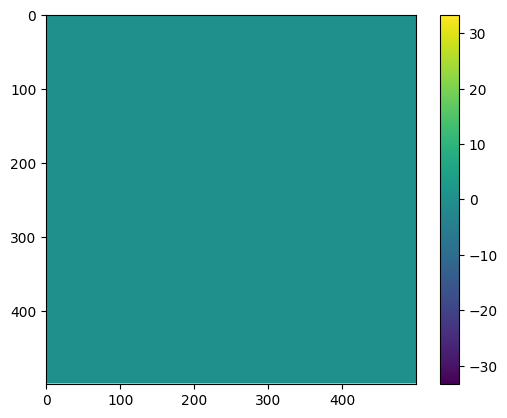

(xˢ=500, yˢ=500, vectorᶜ=x,y) -8.73e-05 ± 1.5e+00 (-3e+01...3e+01)


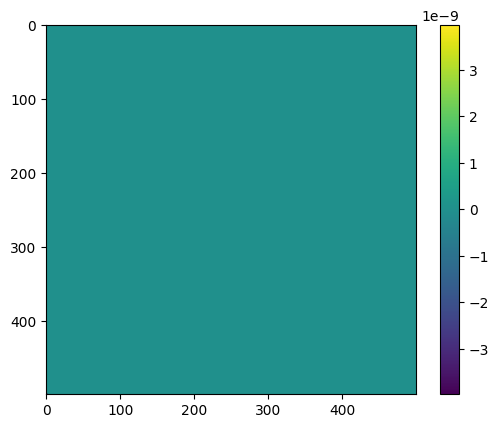

(xˢ=500, yˢ=500, vectorᶜ=x,y) -8.73e-05 ± 1.5e+00 (-3e+01...3e+01)
(xˢ=500, yˢ=500) const 0.8999995589256287
(xˢ=500, yˢ=500) const 0.05000000074505806
(xˢ=500, yˢ=500) const 1.0000001111620804e-06
(xˢ=500, yˢ=500) 1.14e+03 ± 3.3e-01 (1e+03...1e+03)
(dKKᵇ=2, dkᵇ=2, xˢ=500, yˢ=500) 0.083 ± 0.083 (0e+00...2e-01)
(KKᵇ=2, kᵇ=2, xˢ=500, yˢ=500) 2.50e+04 ± 2.5e+04 (0e+00...5e+04)
(xˢ=500, yˢ=500, vectorᶜ=x,y) -8.73e-05 ± 1.5e+00 (-3e+01...3e+01)
(KKᵇ=2, kᵇ=2, xˢ=500, yˢ=500) 3.49e-21 ± 3.5e-21 (0e+00...7e-21)
(dKKᵇ=2, dkᵇ=2, xˢ=500, yˢ=500) 5.47e-19 ± 5.5e-19 (0e+00...1e-18)
(xˢ=500, yˢ=500) -5.23e-05 ± 3.3e-01 (-5e+00...5e+00)


In [ ]:
print(phi[0].sample(geo))
plt.imshow(phi[0].sample(geo).native("x,y"))
plt.colorbar()
plt.show()
print(phi[1].sample(geo))
plt.imshow(phi[1].sample(geo).native("x,y"))
plt.colorbar()
plt.show()
plt.imshow(S_w(phy.compute_p_c(*phi)))
plt.colorbar()
print(S_w(phy.compute_p_c(*phi)))
plt.show()
print(phy.compute_p_c(*phi))
plt.imshow(dsdpc(phy.compute_p_c(*phi)))
plt.colorbar()
plt.show()
print(dsdpc(phy.compute_p_c(*phi)))

plt.imshow(phy.compute_convective_velocity(*phi,dK_w,dK_o).sample(phi_w.geometry).native("x,y")[:,:,0])
plt.colorbar()
plt.show()
print(phy.compute_convective_velocity(*phi,dK_w,dK_o).sample(phi_w.geometry))
plt.imshow(phy.compute_convective_velocity(*phi,dK_w,dK_o).sample(phi_w.geometry).native("x,y")[:,:,1])
plt.colorbar()
plt.show()
print(phy.compute_convective_velocity(*phi,dK_w,dK_o).sample(phi_w.geometry))

print(S_w(phy.compute_p_c(*phi)))
print(K_w_f_t(S_w(phy.compute_p_c(*phi))))
print(dsdpc(phy.compute_p_c(*phi)))
print(phy.compute_p_c(*phi))
print(dK_w(phy.compute_p_c(*phi)))
print(K_w(phy.compute_p_c(*phi)))
print(phy.compute_convective_velocity(*phi,dK_w,dK_o).sample(phi_w.geometry))
print(K_o(phy.compute_p_c(*phi)))
print(dK_o(phy.compute_p_c(*phi)))
#print(phy.compute_convective_velocity(*phi,dK_w,dK_o).sample(phi_o.geometry))
print(phy.phi_w_momentum_eq(*phi, 1e-5).sample(phi_o.geometry))

In [ ]:
print(phy.dtphi_w_1.sample(geo))

(xˢ=240, yˢ=240) -0.005 ± 4.380 (-5e+01...5e+01)


## NS reesidual

In [ ]:
def incompresibble_fluid_loss(up,xt,mu=1,rho=1):
    l=0
    # x-velocity components
    l+=x_grad(up,xt,0,1)[...,2] # dudt
    l+=torch.sum(up[...,:1]*x_grad(up,xt,0,1)[...,:2],axis=-1) # u * grad u
    l+=(mu/rho)*(x_grad(up,xt,2,1)[...,0]) #  dpdx
    l-=(mu/rho)*torch.sum(x_grad(up,xt,0,2)[...,:2],axis=-1) # grad**2 u
    # y-velocity components
    l+=x_grad(up,xt,1,1)[...,2] # dvdt
    l+=torch.sum(up[...,1:2]*x_grad(up,xt,0,1)[...,:2],axis=-1) # v * grad v
    l+=(mu/rho)*(x_grad(up,xt,2,1)[...,1]) #  dpdy
    l-=(mu/rho)*torch.sum(x_grad(up,xt,1,2)[...,:2],axis=-1) # grad**2 v
    return l

### Debug

In [ ]:
x1 = torch.randn((3,1,3)).requires_grad_(True)  #
print(x1)
print(x1.shape)

u1 = torch.stack([
    x1[:,:,0]**0.5,
    torch.sin(x1[:,:,1])+x1[:,:,0]**0.5,
    torch.cos(x1[:,:,0]),
    ],axis=2)

print(u1.shape)

tensor([[[-1.5316, -0.0218,  1.3527]],

        [[ 2.0246,  0.5625, -0.8633]],

        [[ 0.5488, -0.9313,  0.3730]]], requires_grad=True)
torch.Size([3, 1, 3])
torch.Size([3, 1, 3])


In [ ]:
incompresibble_fluid_loss(u1,x1,1,1)-0
#x_grad(u1,x1,0,1)[...,0]
#print(x1[:,:,:1])
#print(x_grad(u1,x1,0,1)[...,:2])
#x_grad(u1,x1,0,1)[...,2]
#x_grad(u1,x1,0,2)[...,:2]

tensor([[   nan],
        [0.9955],
        [0.3642]], grad_fn=<SubBackward0>)

# reaction diffusion approach

In [2]:
from Differentiable_simulation import dK_w,K_w,K_o,grad_phi_dK,two_phase_flow_RD
from phi.torch.flow import *
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### example

In [ ]:

@jit_compile
def reaction_diffusion(u, v, du, dv, f, k, dt):
    uvv = u * v**2
    su = du * field.laplace(u) - uvv + f * (1 - u)
    sv = dv * field.laplace(v) + uvv - (f + k) * v
    return u + dt * su, v + dt * sv


def reaction_diffusion(u, v, du, dv, f, k, dt):
    uvv = u * v**2
    su = du * field.laplace(u) - uvv + f * (1 - u)
    sv = dv * field.laplace(v) + uvv - (f + k) * v
    return u + dt * su, v + dt * sv

/tmp/ipykernel_26679/863439274.py:4: DeprecationWarning: phiml.math.length is deprecated in favor of phiml.math.norm
  CenteredGrid(lambda x: math.cos(math.vec_length(x-50)/3), x=100, y=100) * .5,


TypeError: Image data of dtype object cannot be converted to float

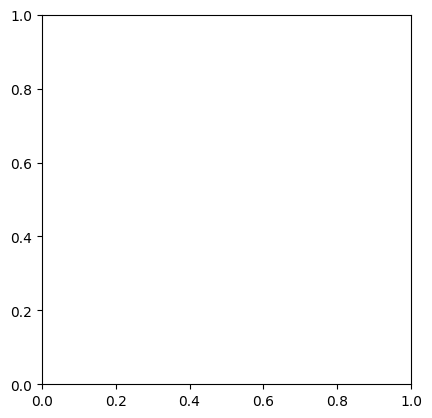

In [6]:
u0 = [
    CenteredGrid(Noise(scale=20, smoothness=1.3), x=100, y=100) * .2 + .1,
    CenteredGrid(lambda x: math.exp(-0.5 * math.sum((x - 50)**2) / 3**2), x=100, y=100),
    CenteredGrid(lambda x: math.cos(math.vec_length(x-50)/3), x=100, y=100) * .5,
]
u0 = stack(u0, batch('initialization'))
plt.imshow(u0)

In [ ]:
maze = {'du': 0.19, 'dv': 0.05, 'f': 0.06, 'k': 0.062}
u_trj, v_trj = iterate(reaction_diffusion, batch(time=100), u0, u0, dt=.5, f_kwargs=maze, substeps=20)


RuntimeError: No user interface available.

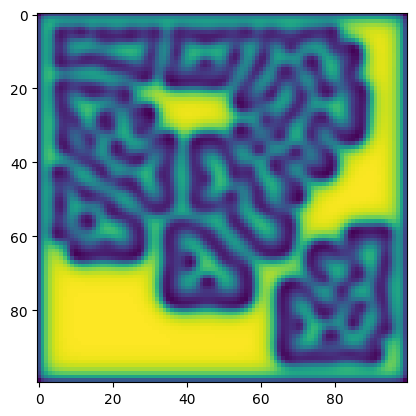

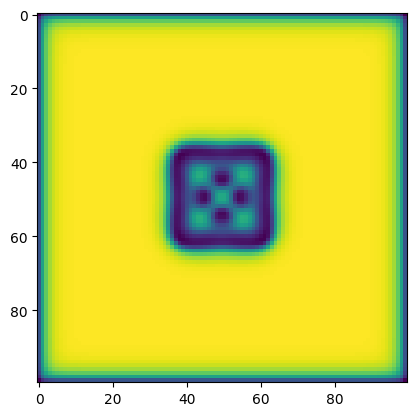

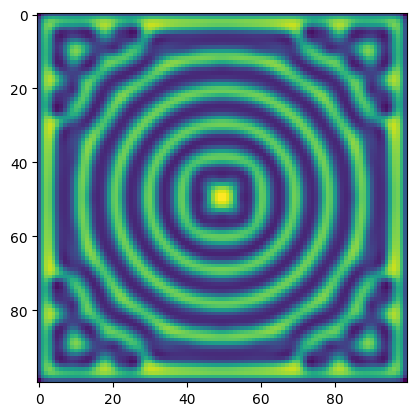

In [17]:

time=50
plt.imshow(u_trj.initialization[0].time[time].values)
plt.show()
plt.imshow(u_trj.initialization[1].time[time].values)
plt.show()
plt.imshow(u_trj.initialization[2].time[time].values)
plt.show()

### 2 phase flow

In [ ]:
from phiml.math import sum as phi_sum

class two_phase_flow_RD(object):
  def __init__(self,phi_w,phi_o,dtphi_w_1,dtphi_o_1,dt,w_advection_solver,o_advection_solver):
    #self.v0=v0
    self.phi_w=phi_w
    self.phi_o=phi_o
    self.dtphi_o_1=dtphi_o_1
    self.dtphi_w_1=dtphi_w_1
    self.dt=dt
    self.p=None
    self.w_advection_solver=w_advection_solver
    self.o_advection_solver=o_advection_solver
    self.K_o=K_o
    self.K_w=K_w


  def compute_p_c(self,phi_w,phi_o):
    p_c=phi_o.sample(phi_o.geometry) -\
    phi_w.sample(phi_w.geometry)
    return p_c

  def compute_convective_velocity(self,phi_a,phi_b,dK_a,dK_b):
    p_c=self.compute_p_c(self.phi_w,self.phi_o)
    convective_velocity = grad_phi_dK(phi_a,dK_a(p_c))\
                         - grad_phi_dK(phi_b,dK_b(p_c))

    V=unstack(convective_velocity,"dk")
    convective_velocity=Field(self.phi_o.geometry,values=vec(x=V[0],y=V[1]))
    return convective_velocity

  #def compute_anisotropic_viscosity_effect(self):
    # reformulate differential solver
    
  def phi_w_momentum_eq(self,phi_w,phi_o, dt):
    #grad_phi_w=field.spatial_gradient(self.phi_w,self.phi_w.boundary)
    p_c=self.compute_p_c(phi_w,phi_o)

    w_advection_term = phi_sum(self.compute_convective_velocity(phi_w,phi_o,dK_w,dK_o)*phi_w.gradient(),"vector").sample(phi_w.geometry)

    print("w phase")
    print(w_advection_term)

    x,y=unstack(phi_sum(self.K_o(p_c),"KK"),"k")
    spatial_diffusion=Field(phi_w.geometry,values=vec(x=x,y=y))
    w_diffusion_term=phi_w.with_values(phi_sum(phi_w.gradient(2)*spatial_diffusion,"vector"))
    print(w_diffusion_term)

    pressure_chage_term = (self.dtphi_o_1)
    print(pressure_chage_term)

    return phi_w + dt * (phi_w.with_values(pressure_chage_term) + phi_w.with_values(w_advection_term) - phi_w.with_values(w_diffusion_term))
  
  def phi_o_momentum_eq(self,phi_o,phi_w, dt):
    #grad_phi_w=field.spatial_gradient(phi_w,phi_w.boundary)
    p_c=self.compute_p_c(phi_w,phi_o)

    print("o phase")
    print(w_advection_term)

    w_advection_term = phi_sum(self.compute_convective_velocity(phi_w,phi_o,dK_w,dK_o)*phi_w.gradient(),"vector").sample(phi_o.geometry)

    x,y=unstack(phi_sum(self.K_w(p_c),"KK"),"k")
    spatial_diffusion=Field(phi_o.geometry,values=vec(x=x,y=y))
    w_diffusion_term=phi_o.with_values(phi_sum(phi_w.gradient(2)*spatial_diffusion,"vector"))

    pressure_chage_term = (self.dtphi_w_1)
    print(pressure_chage_term)

    return phi_o + dt * (phi_o.with_values(pressure_chage_term) + phi_o.with_values(w_advection_term) - phi_o.with_values(w_diffusion_term))
  
  def compute_phi_k(self,phi_w,phi_o,phi_w_1,phi_o_1,dt):
    return (phi_w-phi_w_1)/dt,(phi_o-phi_o_1)/dt


  def implicit_time_step(self, phi_w,phi_o, dt):
    new_phi_w = self.phi_w_momentum_eq(phi_w,phi_o, dt)
    new_phi_o = self.phi_o_momentum_eq(phi_o,phi_w, dt)
    self.dtphi_w_1,self.dtphi_o_1=self.compute_phi_k(new_phi_w,new_phi_o,phi_w,phi_o, dt)
    return new_phi_w,new_phi_o

In [58]:
from Differentiable_simulation import dK_w,K_w,K_o,grad_phi_dK
from phi.torch.flow import *


geo=UniformGrid(x=60, y=60,bounds=Box(x=5e3, y=5e3))
phi_w=Field( geo,values=tensor(0.0),
      boundary= {
          'x-':4e3,
          'x+': 4e3,
          'y-': ZERO_GRADIENT,
          'y+': ZERO_GRADIENT
 })

dtphi_w_1=Field( geo,values=tensor(0.0),
      boundary= {
          'x-': ZERO_GRADIENT,
          'x+': ZERO_GRADIENT,
          'y-': ZERO_GRADIENT,
          'y+': ZERO_GRADIENT
 })

phi_o=Field( geo,values=tensor(1142.0),
      boundary= {
          'x-': 2e3,
          'x+': ZERO_GRADIENT,
          'y-': ZERO_GRADIENT,
         'y+': ZERO_GRADIENT
 })#
dtphi_o_1=Field( geo,values=tensor(0.0),
      boundary= {
          'x-': ZERO_GRADIENT,
          'x+': ZERO_GRADIENT,
          'y-': ZERO_GRADIENT,
          'y+': ZERO_GRADIENT
 })

phy=two_phase_flow_RD(
   phi_w,
    phi_o,
    dtphi_w_1,
    dtphi_o_1,
    dt=0.01,
    #w_advection_solver=lambda v: Solve('CG',1e-4,1e-4,x0=v),
    w_advection_solver=lambda v: Solve('CG-adaptive',1e-4,1e-4,x0=v),
    #o_advection_solver=lambda v: Solve('CG',1e-4,1e-4,x0=v)
    o_advection_solver=lambda v: Solve('CG-adaptive',1e-4,1e-4,x0=v)
)

from Differentiable_simulation import K_o_f_t,K_w_f_t,S_w,dK_o,dK_w,dK_o,dsdpc

print(phy.compute_p_c(phi_w,phi_o))
print(S_w(phy.compute_p_c(phi_w,phi_o)))
print(K_w_f_t(S_w(phy.compute_p_c(phi_w,phi_o))))
print(dsdpc(phy.compute_p_c(phi_w,phi_o)))

print(dK_w(phy.compute_p_c(phi_w,phi_o)))
print(K_w(phy.compute_p_c(phi_w,phi_o)))
print(phy.compute_convective_velocity(phi_o,phi_w,dK_w,dK_o).sample(phi_w.geometry))
print(K_o(phy.compute_p_c(phi_w,phi_o)))
print(dK_o(phy.compute_p_c(phi_w,phi_o)))
#print(phy.compute_convective_velocity(phi_w,phi_o,dK_w,dK_o).sample(phi_o.geometry))
#print(phy.phi_w_momentum_eq(phi_w,phi_o, 1e-4).sample(phi_o.geometry))
#
PD=2e3
SWR=0.3
SOR=0.1
print((lambda s_w:PD*((s_w-SWR)/(1-SWR)))(0.3))
print((lambda s_w:PD*((s_w-SWR)/(1-SWR)))(0.7))

(xˢ=60, yˢ=60) const 1142.0
(xˢ=60, yˢ=60) const 0.8999999761581421
(xˢ=60, yˢ=60) const 0.04999999329447746
(xˢ=60, yˢ=60) const 9.999999974752427e-07
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 0.083 ± 0.083 (0e+00...2e-01)
(KKᵇ=2, kᵇ=2, xˢ=60, yˢ=60) 2.50e+04 ± 2.5e+04 (0e+00...5e+04)
(xˢ=60, yˢ=60, vectorᶜ=x,y) -0.007 ± 0.078 (-9e-01...0e+00)
(KKᵇ=2, kᵇ=2, xˢ=60, yˢ=60) 3.49e-21 ± 3.5e-21 (0e+00...7e-21)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.47e-19 ± 5.5e-19 (0e+00...1e-18)
0.0
1142.857142857143


In [59]:
phi_t=[]
phi=(phi_w,phi_o)
phi_t.append(phi)
for i in range(500):
    phi=phy.implicit_time_step(*phi,1e-1)
    phi_t.append(phi)

In [54]:
print(S_w(phy.compute_p_c(*phi_t[-1])))

(xˢ=60, yˢ=60) nan ± nan (nan...nan)


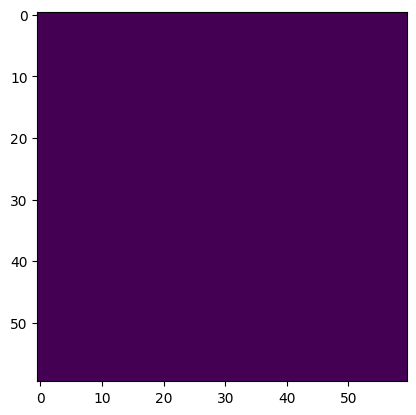

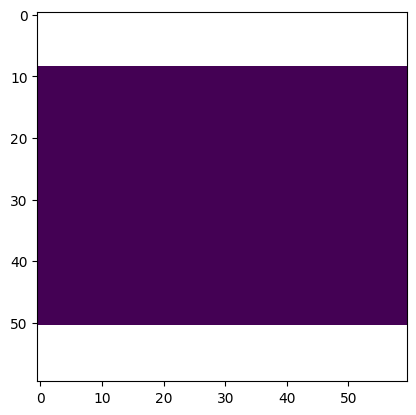

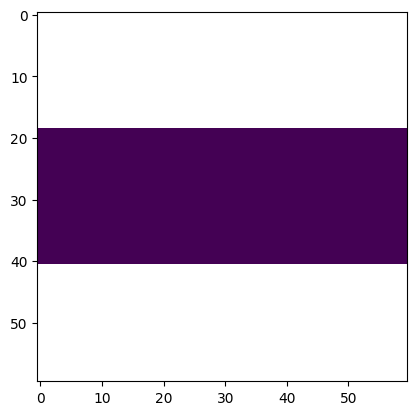

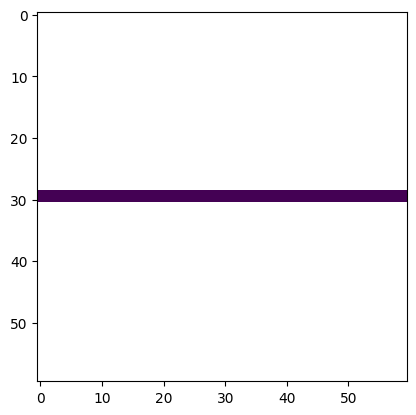

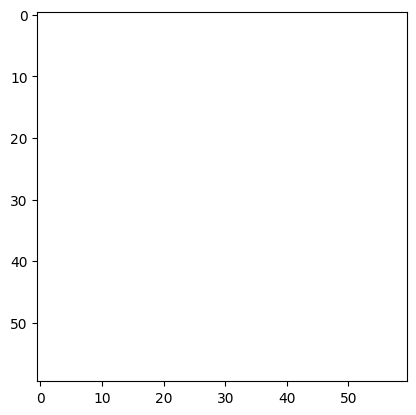

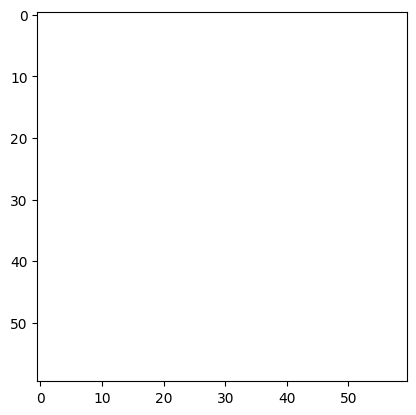

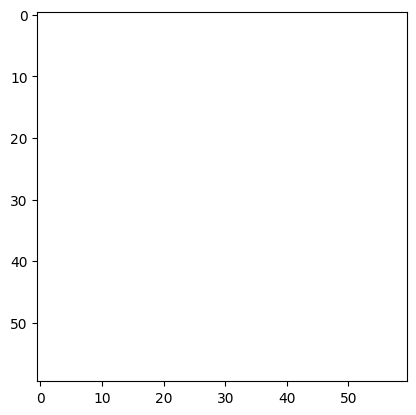

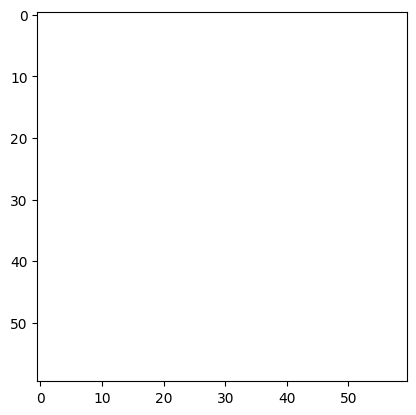

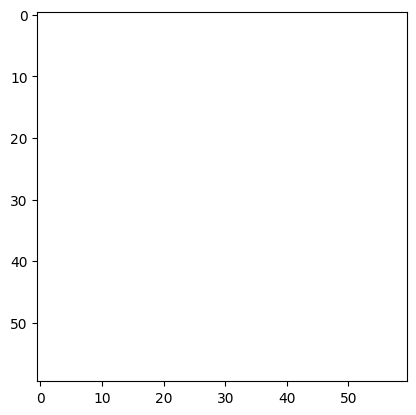

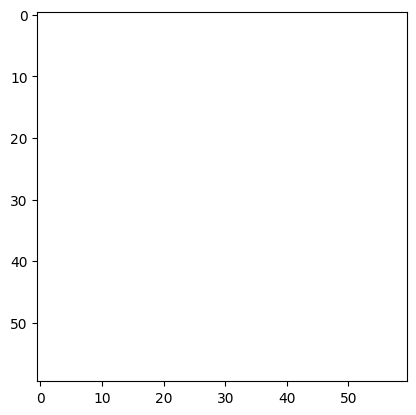

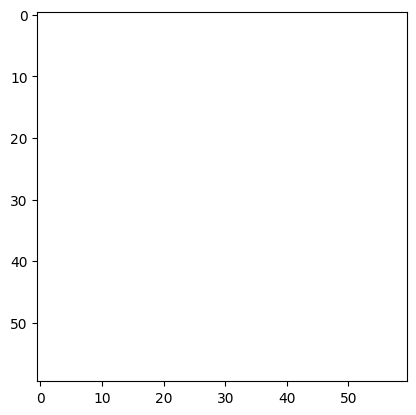

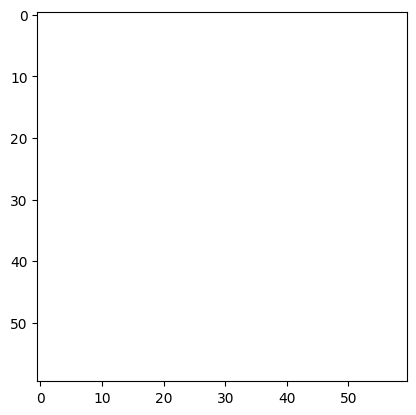

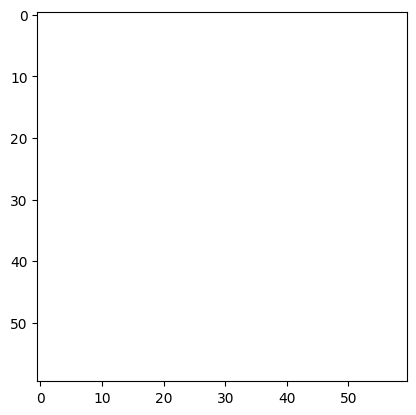

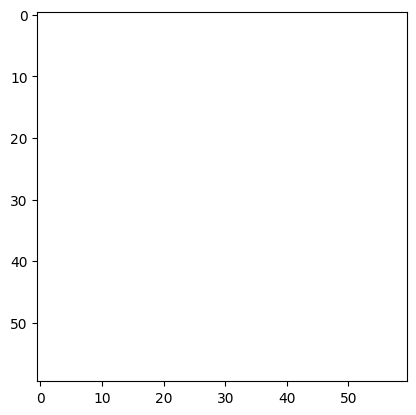

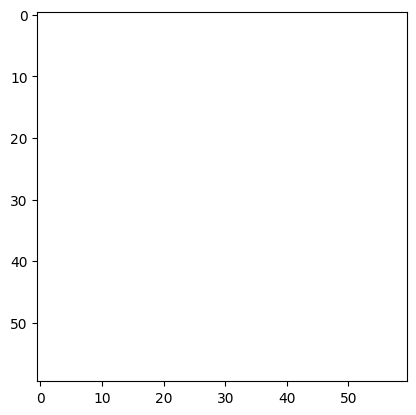

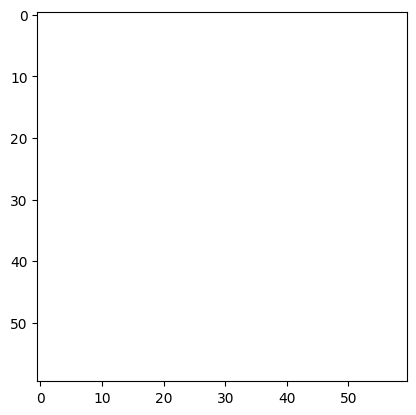

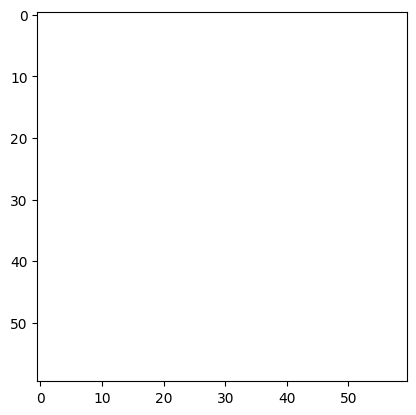

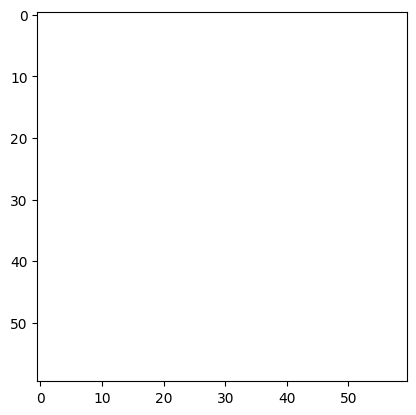

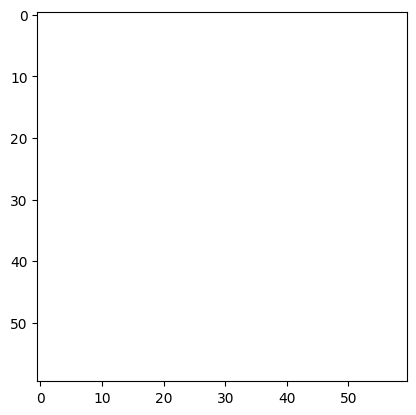

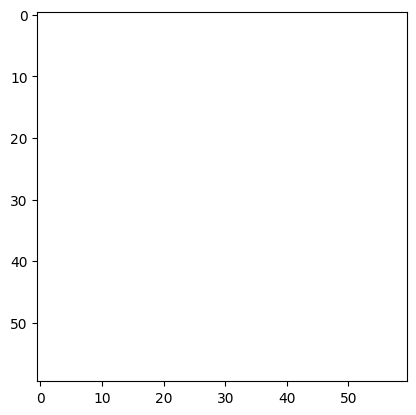

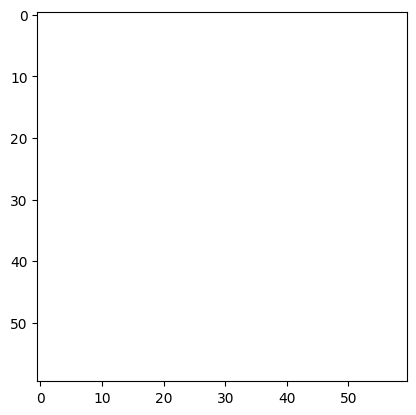

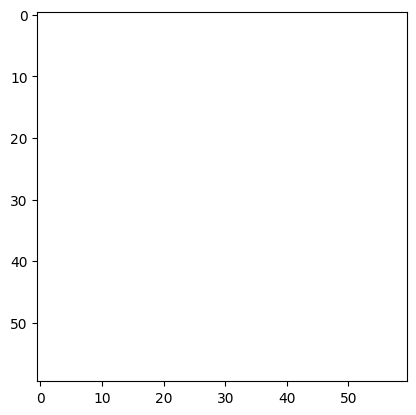

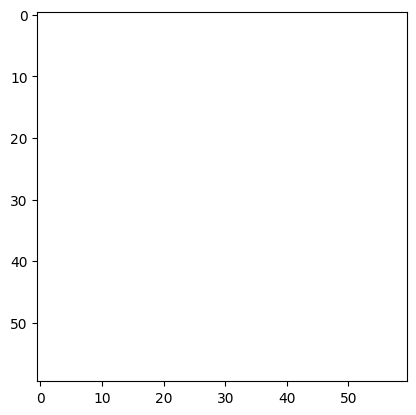

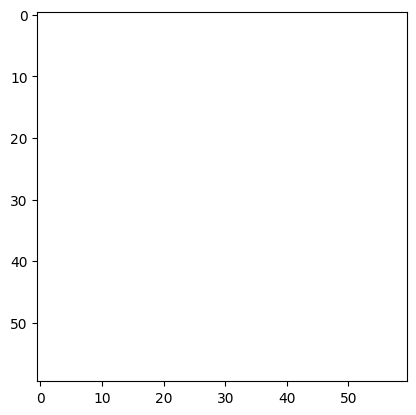

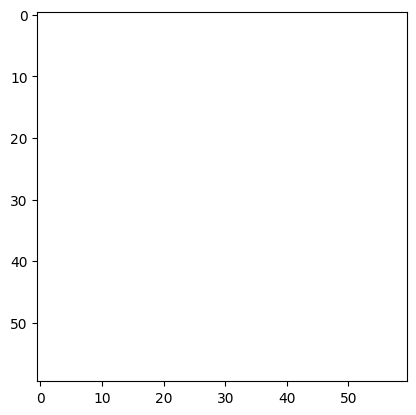

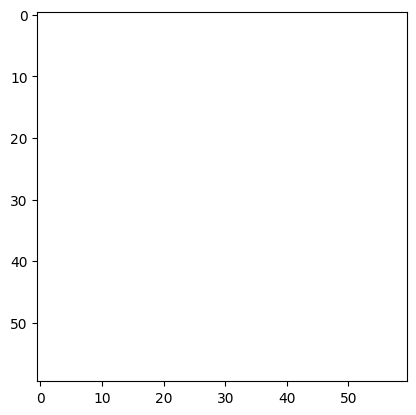

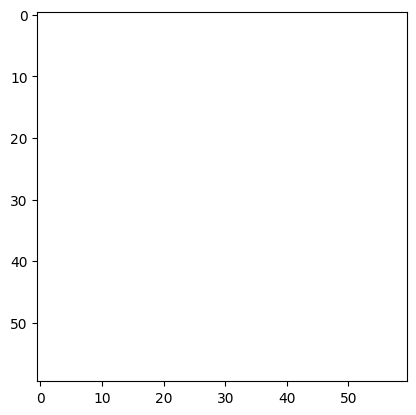

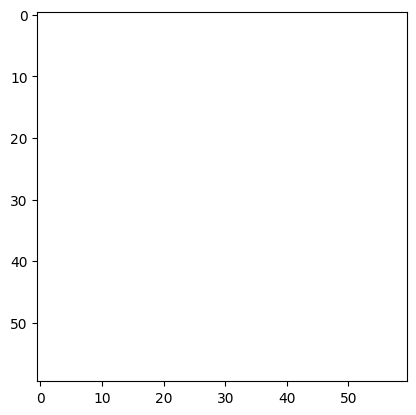

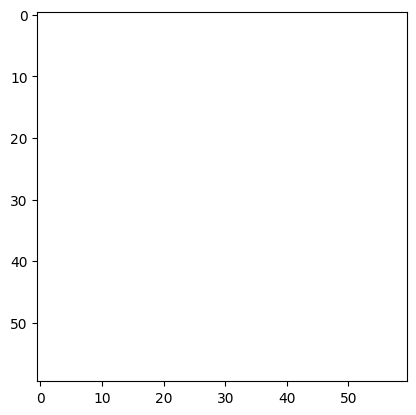

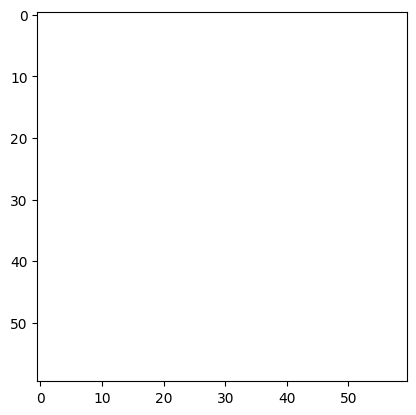

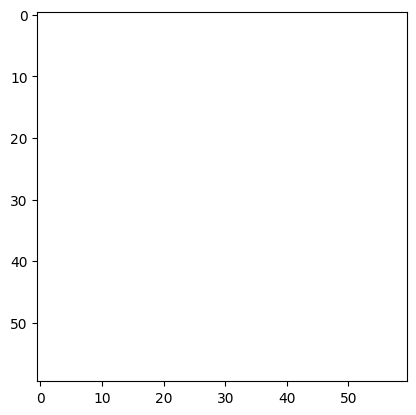

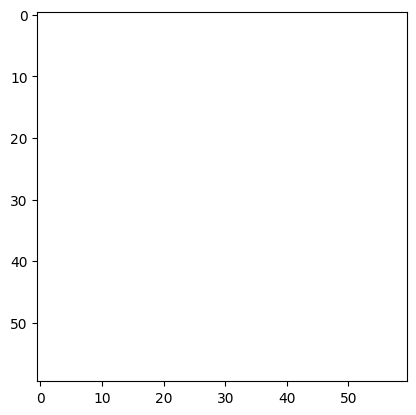

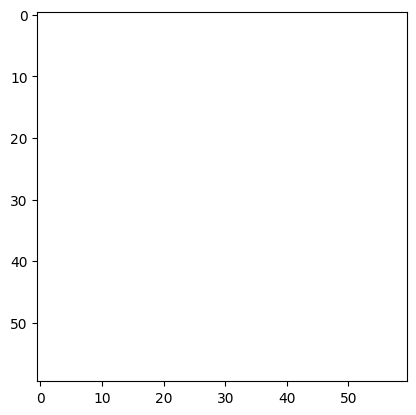

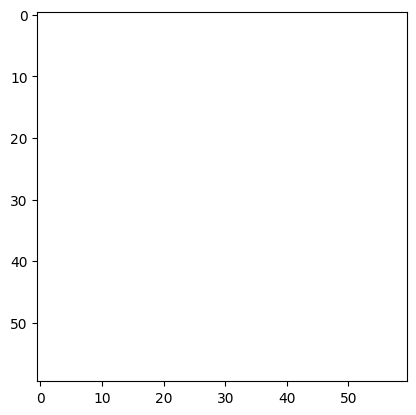

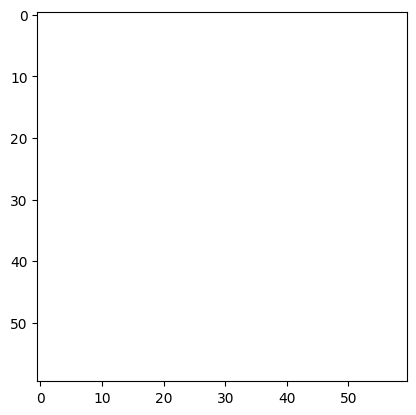

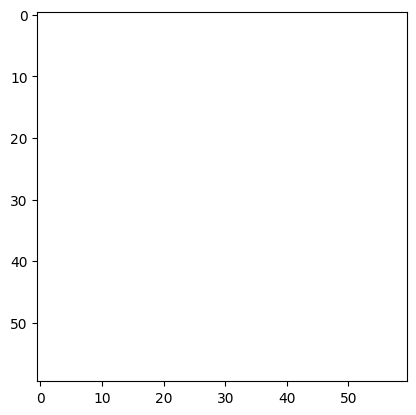

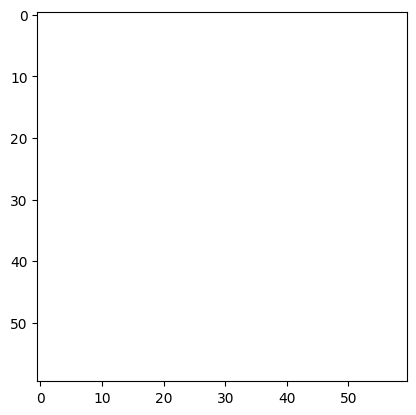

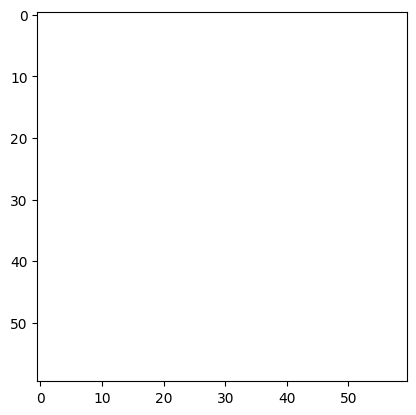

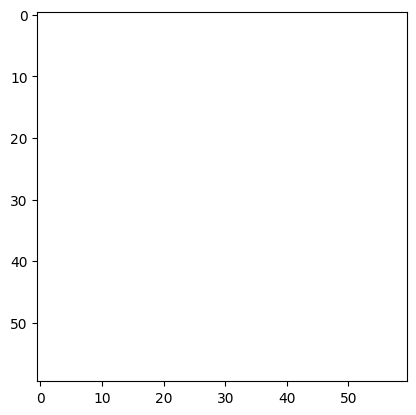

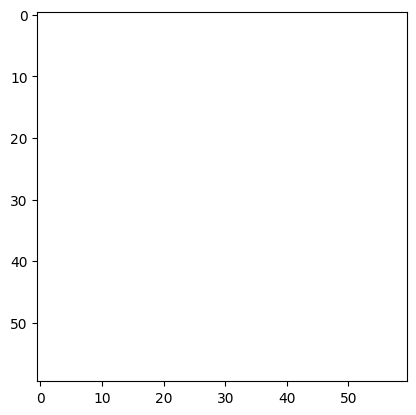

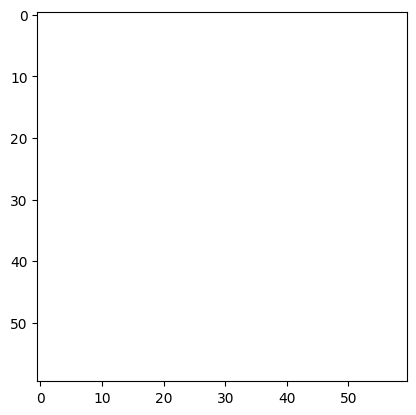

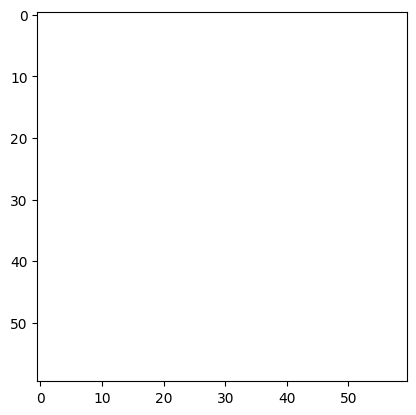

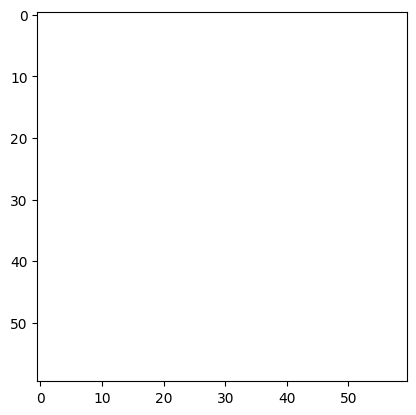

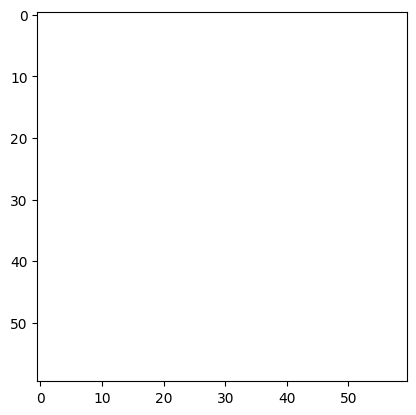

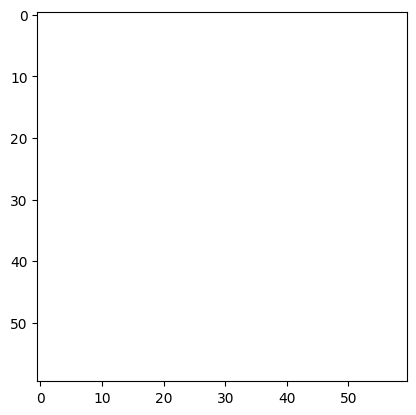

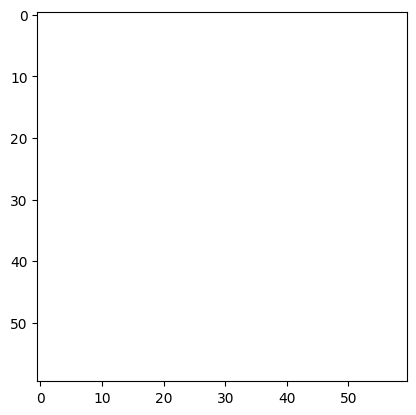

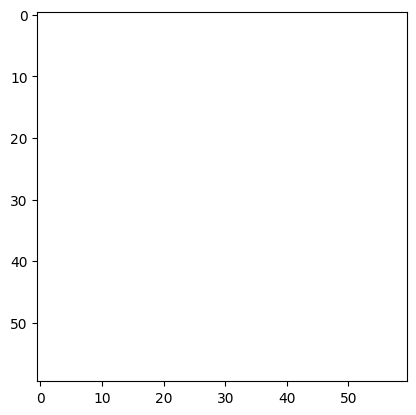

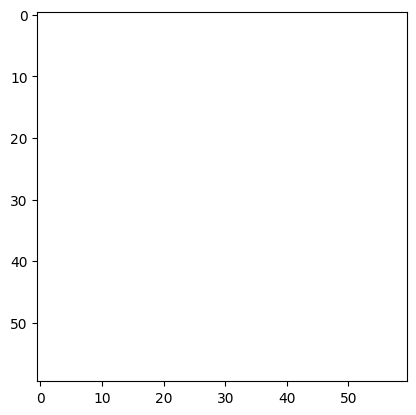

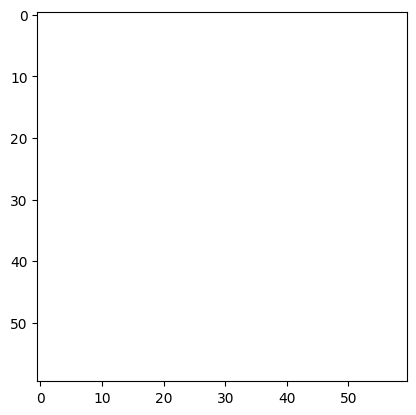

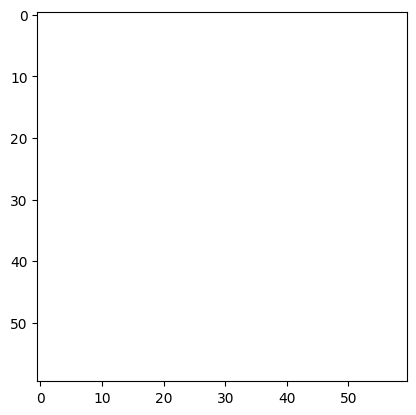

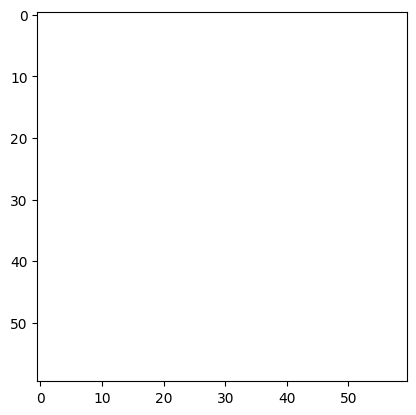

In [61]:

#for f in np.array(phi_t):
for f in phi_t[::10]:
    plt.imshow(S_w(phy.compute_p_c(*f)))
    plt.show()
